In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# General CBCP Equilibrium Solver

## (Special Case) Quartic Polynomial Latency Functions

In [2]:
x_temp = np.array([0, 1, 2, 3, 4])
x_temp[-2:]

array([3, 4])

In [3]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
# num_cols = arr.shape[1]
num_cols = 3
# arr[:, -num_cols:] - arr[:, -num_cols-1:-1]

np.linalg.norm(arr, axis=0)


array([12.56980509, 14.03566885, 15.55634919, 17.11724277, 18.70828693])

In [4]:
grad = np.array([0, 1, 2, 3, 4])

grad[2:]

array([2, 3, 4])

In [147]:
# Latency Function: a_4 x^4 + a_3 x^3 + a_2 x^2 + a_1 x + a_0

# def solve_CBCP_iter(v_ineligible_list, v_eligible_list, a = , num_iters = 1000, alpha_0 = ):
    
#     # TODO
    
#     return y_opt


def diff_vecs(arr):
    num_cols = arr.shape[1]
    diff_arr = arr[:, :num_cols - 1] - arr[:, 1:num_cols]
    
    return 

def solve_CBCP_iter_11(tau, B, v_I, v_E, a = np.array([0.5, 1.0]), input_flow = 1, \
                       num_iters_max = 5000, error_bound = 1E-3, diffs_num_cols = 10, \
                       y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0]) ):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # a = (a_0, a_1)
    
#     print()    
#     print("Starting solve_CBCP_iter_11:")
#     print()
    
    # Initialize y_iters:
    y_iters = np.zeros((5, num_iters_max))
    
    y_el_var_current = y_init[0:3]
    y_in_var_current = y_init[3:]
    
    for k in range(num_iters_max):
        
        if k % 10 == 0:
            print("Inner iter:", k)
        
        # y_el: \hat y_1 E, \tilde y_1 E, y_2 E
        y_el_var = cp.Variable(3)
        # y_in: y_1 I, y_2 I
        y_in_var = cp.Variable(2)
        
        # Compute gradient:
        
        grad = np.zeros(5)
        grad[0] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_E
        grad[1] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0]
        grad[2] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        grad[3] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_I
        grad[4] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        
        ## Apply Frank-Wolfe:
        # Compute next iterate:
        
#         objective = cp.Minimize(0.5 * a[1] * (y_el_var[0] + y_el_var[1] + y_in_var[0])**2 \
#                                 + a[0] * (y_el_var[0] + y_el_var[1] + y_in_var[0]) \
#                                 + y_in_var[0] * tau / v_I + y_el_var[0] * tau / v_E \
#                                 + 0.5 * a[1] * (y_el_var[2] + y_in_var[1])**2 \
#                                 + a[0] * (y_el_var[2] + y_in_var[1]) )
        
        objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

        constraints = []
        constraints += [y_el_var >= 0, y_in_var >= 0]
        constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
        constraints += [y_el_var[1] * tau <= B]
    
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        
#         print("grad:", grad)
#         print("y_el_var.value:", y_el_var.value)
#         print("y_in_var.value:", y_in_var.value)
#         print("y_el_var_current:", y_el_var_current)
#         print("y_in_var_current:", y_in_var_current)
        
        y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
        y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)
        
#         print("y_el_var_current (new):", y_el_var_current)
#         print("y_in_var_current (new):", y_in_var_current)
#         print()
        
        y_iters[0:3, k] = y_el_var_current
        y_iters[3:, k] = y_in_var_current
        
        if k >= diffs_num_cols + 2:
            diffs = np.linalg.norm(y_iters[:, k-diffs_num_cols-1:k-2] - y_iters[:, k-diffs_num_cols:k-1], axis = 0)

            if np.max(diffs) < error_bound:
                break
    
    return y_el_var_current, y_in_var_current

def solve_CBCP_direct_11(tau, B, v_I, v_E, a = np.array([1, 0]), input_flow = 1):

    # y_el: \hat y_1, \tilde y_1, y_2
    y_el = cp.Variable(3)
    # y_in: y_1, y_2
    y_in = cp.Variable(2)
    
    objective = cp.Minimize(0.5 * a[1] * (y_el[0] + y_el[1] + y_in[0])**2 \
                            + a[0] * (y_el[0] + y_el[1] + y_in[0]) \
                            + y_in[0] * tau / v_I + y_el[0] * tau / v_E \
                            + 0.5 * a[1] * (y_el[2] + y_in[1])**2 \
                            + a[0] * (y_el[2] + y_in[1]) )
    
    constraints = []
    constraints += [y_el >= 0, y_in >= 0]
    constraints += [cp.sum(y_el) == 1, cp.sum(y_in) == 1]
    constraints += [y_el[1] * tau <= B]
    
    prob = cp.Problem(objective, constraints)
    
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    # The optimal value for x is stored in `x.value`.
    print("y_el.value:", y_el.value)
    print("y_in.value:", y_in.value)

    return y_el.value, y_in.value


In [141]:
def welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, y_el, y_in, a):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # y_el = (\hat y_1 E, \tilde y_1 E, y_2 E)
    # y_in = (y_1 I, y_2 I)
    
    ell_1 = a[1] * (y_el[0] + y_el[1] + y_in[0]) + a[0]
    ell_2 = a[1] * (y_el[2] + y_in[1]) + a[0]
    
    obj_E = tau * y_el[0] + v_E * (ell_1 * (y_el[0] + y_el[1]) + ell_2 * y_el[2])
    obj_R = tau * (y_el[0] + y_in[0])
    obj_I = tau * y_in[0] + v_I * (ell_1 * (y_el[0] + y_el[1] + y_el[2]) + ell_2 * (y_in[0] + y_in[1]) )
    
#     print()
#     print("tau:", tau)
#     print("y_el.shape:", y_el.shape)
#     print("y_in.shape:", y_in.shape)
#     print("ell_1:", ell_1)
#     print("ell_2:", ell_2)
#     print("obj_E.shape:", obj_E.shape)
#     print("obj_R.shape:", obj_R.shape)
#     print("obj_I.shape:", obj_I.shape)
#     print()

    return lambda_E * obj_E - lambda_R * obj_R + lambda_I * obj_I

    

In [157]:
def proj_tau_B_11(tau, B):
    if B <= tau and 0 <= tau <= 1 and 0 <= B <= 1:
        return tau, B
    elif tau > 1 and 0 < B <= 1:
        return 1.0, B
    elif tau > 1 and B <= 0:
        return 1.0, 0.0
    elif 0 < tau <= 1 and B < 0:
        return tau, 0.0
    elif tau <= 0 and B + tau < 0:
        return 0.0, 0.0
    elif B + tau >= 0 and B + tau < 2 and B > tau:
        return (B + tau)/2, (B + tau)/2
    elif B + tau >= 2 and B > 1:
        return 1.0, 1.0
    else:
        assert 1 == 0, "This case should not happen!"

In [ ]:
# arr_temp = np.zeros(5)
# arr_temp[0] = 1

## Grid Search:

In [92]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.5, 1.0])
input_flow = 1
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0


grid_size = 0.05
tau_arr = (np.arange(int(1/grid_size)) + 1) * grid_size
B_arr = (np.arange(int(1/grid_size)) + 1) * grid_size

welfare_obj_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0]))
y_el_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 3))
y_in_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 2))
welfare_obj_list = []

for tau_index, tau in enumerate(tau_arr):
    for B_index, B in enumerate(B_arr):
        if B < tau:
            print("tau:", tau)
            print("B:", B)
            y_el_arr[tau_index, B_index, :], y_in_arr[tau_index, B_index, :] \
                = solve_CBCP_iter_11(tau = tau, B = B, v_I = v_I, v_E = v_E, a = a, input_flow = input_flow, \
                                     num_iters_max = num_iters_max, error_bound = error_bound, diffs_num_cols = diffs_num_cols, \
                                     y_init = y_init)
            
            welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, \
                                                              y_el = y_el_arr[tau_index, B_index, :], y_in = y_in_arr[tau_index, B_index, :], \
                                                              a = a)
            welfare_obj_list.append(welfare_obj_arr[tau_index][B_index])
            
            print()

time_2 = time.time()

print("Time:", time_2 - time_1)



tau: 0.1
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.06428571428571428
obj_I: 3.0428571428571427

tau: 0.15000000000000002
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.10714285714285716
obj_I: 3.0642857142857145

tau: 0.15000000000000002
B: 0.1

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.08571428571428573
obj_I: 3.0642857142857145

tau: 0.2
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.15000000000000002
obj_I: 3.085714285714286

tau: 0.2
B: 0.1

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.12857142857142856
obj_I: 3.085714285714286

tau: 0.2
B: 0.15000000000000002

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.10714285714285712
obj_I: 3.085714285714286

tau: 0.25
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.15
obj_I: 3.107142857142857

tau: 0.25
B: 0.1

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.1392857142857143
obj_I: 3.107142857142857

tau: 0.25
B: 0.1500000000000000

obj_E.shape: ()
obj_R: 0.1321428571428572
obj_I: 3.1285714285714286

tau: 0.65
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.3214285714285714
obj_I: 3.2785714285714285

tau: 0.65
B: 0.1

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.31785714285714284
obj_I: 3.2785714285714285

tau: 0.65
B: 0.15000000000000002

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.3142857142857143
obj_I: 3.278571428571428

tau: 0.65
B: 0.2

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.33392857142857146
obj_I: 3.3017857142857143

tau: 0.65
B: 0.25

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.3303571428571429
obj_I: 3.3017857142857143

tau: 0.65
B: 0.30000000000000004

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.16428571428571437
obj_I: 3.1392857142857142

tau: 0.65
B: 0.35000000000000003

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.3232142857142858
obj_I: 3.3017857142857143

tau: 0.65
B: 0.4

Starting solve_CBCP_iter_11:

obj_E.shape:

obj_E.shape: ()
obj_R: 0.06785714285714287
obj_I: 3.060714285714286

tau: 0.8500000000000001
B: 0.8

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.0642857142857143
obj_I: 3.060714285714286

tau: 0.9
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.5107142857142857
obj_I: 3.45

tau: 0.9
B: 0.1

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.5071428571428571
obj_I: 3.4499999999999997

tau: 0.9
B: 0.15000000000000002

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.5035714285714286
obj_I: 3.45

tau: 0.9
B: 0.2

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.275
obj_I: 3.225

tau: 0.9
B: 0.25

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.2714285714285714
obj_I: 3.225

tau: 0.9
B: 0.30000000000000004

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.26785714285714285
obj_I: 3.225

tau: 0.9
B: 0.35000000000000003

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.29642857142857143
obj_I: 3.2571428571428576

tau: 0.9
B: 0.4



In [115]:
# welfare_obj_arr

argmin_indices_wrapped = np.where(welfare_obj_arr == min(welfare_obj_list))
argmin_indices = [argmin_indices_wrapped[0][0], argmin_indices_wrapped[1][0]]
# argmin_indices
argmin_tau = tau_arr[argmin_indices[0]]
argmin_B = B_arr[argmin_indices[1]]

print("argmin_tau:\n", np.round(argmin_tau, 2))
print("\nargmin_B:\n", np.round(argmin_B, 2))

welfare_obj_arr[argmin_indices[0], argmin_indices[1] ]


argmin_tau:
 0.85

argmin_B:
 0.7


3.84491914412824

In [112]:
# welfare_obj_arr

In [11]:
# # lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower' ) 
# plt.colorbar() 
# plt.xlabel("Toll") 
# plt.ylabel("Budget")

Text(0, 0.5, 'Budget')

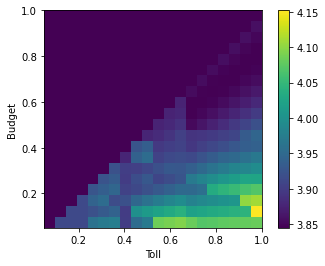

In [12]:
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 
plt.imshow(welfare_obj_arr.T, extent=[np.min(tau_arr), np.max(tau_arr), np.min(B_arr), np.max(B_arr)], \
           vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 

plt.colorbar() 
plt.xlabel("Toll")
plt.ylabel("Budget")
# plt.xticks(x_positions, x_labels)

## Chinmay's Algorithm:

In [158]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.5, 1.0])
input_flow = 1
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.05, 0.95, 0.95, 0.05])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0

tau_max, B_max = 1.0, 1.0
d = 2
num_iters = 1000
tau = np.zeros(num_iters)
tau_perturbed = np.zeros(num_iters)
B = np.zeros(num_iters)
B_perturbed = np.zeros(num_iters)
tau_B_iters = np.zeros((2, num_iters))
delta = np.zeros(num_iters)
eta = np.zeros(num_iters)
eta_bar = 3.0
delta_bar = 1.0

B[0] = 0.8
tau[0] = 0.9

for i in range(num_iters-1):
    
    print()
    print("Iter:", i)
    
    eta[i] = eta_bar * (i+1)**(-1/2) * d**(-1)
    delta[i] = delta_bar * (i+1)**(-1/4) * d**(-1/2)
    w_i_unnormalized = np.random.randn(2)
    w_i = w_i_unnormalized / np.linalg.norm(w_i_unnormalized)
    print("w_i:", w_i)
    tau_perturbed[i] = tau[i] + delta[i] * w_i[0]
    B_perturbed[i] = B[i] + delta[i] * w_i[1]
    
    if tau_perturbed[i] > B_perturbed[i] or tau_perturbed[i] < 0 or B_perturbed[i] < 0:
        tau_perturbed[i], B_perturbed[i] = proj_tau_B_11(tau_perturbed[i], B_perturbed[i])
    
    # TODO
#     if B_perturbed[i] <= tau_perturbed[i] and B_perturbed[i] >= 0 and tau_perturbed[i] >= 0:        
    
#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):")
#     print()
    y_el, y_in = solve_CBCP_iter_11(tau = tau[i], B = B[i], v_I = v_I, v_E = v_E, a = a, input_flow = input_flow, \
                                     num_iters_max = num_iters_max, error_bound = error_bound, diffs_num_cols = diffs_num_cols, \
                                     y_init = y_init)
    
    print("tau[i]:", tau[i])
    print("B[i]:", B[i])
    print("tau_perturbed[i]:", tau_perturbed[i])
    print("B_perturbed[i]:", B_perturbed[i])
#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (perturbed):")
#     print()
    y_el_perturbed, y_in_perturbed = solve_CBCP_iter_11(tau = tau_perturbed[i], B = B_perturbed[i], v_I = v_I, v_E = v_E, a = a, input_flow = input_flow, \
                                                        num_iters_max = num_iters_max, error_bound = error_bound, diffs_num_cols = diffs_num_cols, \
                                                        y_init = y_init)
    
    print("y_el:", y_el)
    print("y_in:", y_in)
    print("y_el_perturbed:", y_el_perturbed)
    print("y_in_perturbed:", y_in_perturbed)
    
    welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau[i], v_I = v_I, v_E = v_E, \
                          y_el = y_el, y_in = y_in, a = a)
    welfare_perturbed = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau_perturbed[i], v_I = v_I, v_E = v_E, \
                                    y_el = y_el_perturbed, y_in = y_in_perturbed, a = a)
    
    print("welfare:", welfare)
    print("welfare_perturbed:", welfare_perturbed)
#     print("tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):\n", tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare))
    
    tau[i+1] = tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare)
    B[i+1] = B[i] - eta[i] * (d/delta[i]) * w_i[1] * (welfare_perturbed - welfare)

    if not (B[i+1] <= tau[i+1] and 0 <= tau[i+1] <= 1 and 0 <= B[i+1] <= 1):
        tau[i+1], B[i+1] = proj_tau_B_11(tau[i+1], B[i+1])
        
    if i >= diffs_num_cols + 2:
        tau_diffs = tau[i-diffs_num_cols : i-1] - tau[i-diffs_num_cols+1 : i]
        B_diffs = B[i-diffs_num_cols : i-1] - B[i-diffs_num_cols+1 : i]
        
        print("tau[0:10]:", tau[0:10])
        print("B[0:10]:", B[0:10])
        print("tau_diffs:", tau_diffs)
        print("B_diffs:", B_diffs)
        
        if max(np.max(np.absolute(tau_diffs)), np.max(np.absolute(B_diffs))) < error_bound:
            break

time_2 = time.time()

print()
print("Time:", time_2 - time_1)




Iter: 0
w_i: [0.4912257  0.87103233]
Inner iter: 0
Inner iter: 10
Inner iter: 20
Inner iter: 30
tau[i]: 0.9
B[i]: 0.8
tau_perturbed[i]: 1.2473490232844922
B_perturbed[i]: 1.4159128639858964
Inner iter: 0
Inner iter: 10
Inner iter: 20
Inner iter: 30
y_el: [3.73482726e-04 8.82913165e-01 1.16713352e-01]
y_in: [0.00336134 0.99663866]
y_el_perturbed: [0.         0.99365079 0.00634921]
y_in_perturbed: [0.0031746 0.9968254]
welfare: 3.847864426816478
welfare_perturbed: 3.898119425547997

Iter: 1
w_i: [ 0.51294913 -0.85841901]
Inner iter: 0
Inner iter: 10
Inner iter: 20
Inner iter: 30
tau[i]: 0.7952638516526608
B[i]: 0.6142837988099751
tau_perturbed[i]: 1.0
B_perturbed[i]: 0.10386480353041505
Inner iter: 0
Inner iter: 10
Inner iter: 20
Inner iter: 30
Inner iter: 40
Inner iter: 50
Inner iter: 60
Inner iter: 70
Inner iter: 80
Inner iter: 90
Inner iter: 100
Inner iter: 110
Inner iter: 120
Inner iter: 130
Inner iter: 140
Inner iter: 150
Inner iter: 160
Inner iter: 170
Inner iter: 180
Inner iter: 

KeyboardInterrupt: 

In [136]:
arr = -np.arange(10)
np.absolute(arr)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [111]:
# tau[-1], B[-1]
welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau[-1], v_I = v_I, v_E = v_E, \
                          y_el = y_el, y_in = y_in, a = a)
welfare


tau: 0.9752375837762047
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()



3.869387755102041

In [80]:
grad = np.array([3.11430535, 1.501, 1.501, 2.46858321, 1.501])

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_el_var = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_in_var = cp.Variable(2)

objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

constraints = []
constraints += [y_el_var >= 0, y_in_var >= 0]
constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
constraints += [y_el_var[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("grad:", grad)
print("y_el_var.value:", y_el_var.value)
# print("y_el_var_current:", y_el_var_current)
print("y_in_var.value:", y_in_var.value)
# print("y_in_var_current:", y_in_var_current)
print()

# y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
# y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)

# y_iters[0:3, k] = y_el_var_current
# y_iters[3:, k] = y_in_var_current

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()

# Solver=SCS,verbose=False

grad: [3.11430535 1.501      1.501      2.46858321 1.501     ]
y_el_var.value: [0. 0. 1.]
y_in_var.value: [0. 1.]



In [ ]:
# y_el_var
# y_in_var
# np.hstack((y_el_var, y_in_var))

# Scratch Work:

In [ ]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
# for i in range(2):
#     constraints += [x[i] >= 2]
# constraints += [x[i] >=2 for i in range(2)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()


# Old Code Below:

# Budget vs Discount - Theory

## 1 Eligible group, 1 Ineligible group (Theory)

In [ ]:
def F_11(val, ell, tau, alpha):
    return ell(val) + (1 - alpha) * tau - ell(2 - val)

def y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0, num_iters = 20):
    # Searches for y^\star satisfying ell(y^\star) + (1 - \alpha) \tau = ell(2 - y^\star)
    
    assert tau < ell(ub_init) - ell(lb_init), "We must have tau < ell(2.0) - ell(0.0), else is trivial."
    assert 0.0 <= alpha <= 1.0, "We must have 0.0 <= alpha <= 1.0"
    assert ell(lb_init) + (1.0 - alpha) * tau < ell(ub_init)
    
    lb = lb_init
    ub = ub_init
    mid_val = (lb + ub)/2
    
    for k in range(num_iters):
#         print("F:", F_11(mid_val, ell, tau, alpha))
#         print("lb:", lb)
#         print("ub:", ub)
#         print("mid_val:", mid_val)
#         print()
        
        if F_11(mid_val, ell, tau, alpha) < 0:
            lb = mid_val
        else:
            ub = mid_val
        mid_val = (lb + ub)/2
    
    return (lb + ub)/2

# def fixed_point_eqn():
    


In [ ]:
t_1 = time.time()

ell = lambda x: x**4 / 16
# ell = lambda x: np.log(1 + np.exp(x))
# alpha = 0.0

# # Case 1: 
# tau = 0.4
# v_E = 1
# v_I = 1.25

# # Case 2: 
# tau = 0.7
# v_E = 1
# v_I = 1.25

# Case 3: 
tau = 0.7
v_E = 1
v_I = 2.5

num_alpha_grid_points = 100 # Should be even
alpha_vals = np.linspace(0, 1.0, num = num_alpha_grid_points + 1)

y_star_zero = y_star_11(ell, tau, alpha = 0.0, lb_init = 0.0, ub_init = 2.0)
# print("y_star_zero:", y_star_zero)

y_star_vals = np.array([y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0) for alpha in alpha_vals])
y_star_vals_budget = alpha_vals
index_max = max([k for k in list(range(num_alpha_grid_points)) if alpha_vals[k] <= 1 - v_E/v_I])
# print("index_min:", index_min)
# print("alpha_vals[index_min]:", alpha_vals[index_min])
# print("y_star_vals_budget:", y_star_vals_budget)
# print()

# print("y_star_vals:", y_star_vals)
# print()

y_star_vals_discount = np.copy(y_star_vals)
for k in range(y_star_vals_discount.shape[0]):
    if k <= index_max:
        y_star_vals_discount[k] = 0.0

tau_thresh_for_alpha_3 = 2 * v_E * (ell(1) - ell(1 - 1E-6)) / 1E-6
index_for_alpha_3 = max([k for k in list(range(num_alpha_grid_points)) if y_star_vals[k] >= alpha_vals[k] ])
alpha_3 = (y_star_vals[index_for_alpha_3] + y_star_vals[index_for_alpha_3 + 1])/2

# print("y_star_vals_budget:", y_star_vals_budget)

# print("y_star_vals_budget:", y_star_vals_budget)


t_2 = time.time()
print("Time:", t_2 - t_1)

In [ ]:
print("1 - v^E / v^I:", 1 - v_E/v_I)
print("alpha_3:", alpha_3)

In [ ]:
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False

plt.plot(alpha_vals, y_star_vals_discount, 'red')
plt.plot(alpha_vals, y_star_vals_budget, 'blue')
# plt.scatter(alpha_vals, y_star_vals_discount, marker = 'o', s = 0.5, color = 'purple')
# plt.scatter(alpha_vals, y_star_vals_budget, marker = 'o', s = 0.5, color = 'black')
plt.xlim([0, 1.0])
plt.ylim([-0.2, 1.2])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'$\displaystyle \alpha$', fontsize=24)
plt.ylabel(r'$\displaystyle y^C, y^D$', fontsize=24)
# plt.ylabel(r'$\displaystyle \ln(L^t - L^\star)$', fontsize=16)

# Scratch Work:

In [ ]:
# m_sample = gp.Model()
